# Roboflow to Hugging Face ETL Process

## Install Python Libraries

In [ ]:
!pip install -q roboflow datasets datasets[vision] python-dotenv matplotlib seaborn

## Configuration

In [ ]:
import os
import sys
from dataclasses import dataclass
from typing import List

@dataclass
class Config:
    workspace: str
    project: str
    version: int
    project_location: str
    formats: List[str]
    api_key: str

def is_colab():
    return 'google.colab' in sys.modules

def get_api_key():
    api_key = os.getenv('ROBOFLOW_API_KEY')
    if not api_key:
        if is_colab():
            from google.colab import userdata
            api_key = userdata.get('ROBOFLOW_API_KEY')
        if not api_key:
            api_key = input("Please enter your Roboflow API key: ")
    return api_key

def load_config() -> Config:
    api_key = get_api_key()
    return Config(
        workspace="roboflow-100",
        project="bccd-ouzjz",
        version=2,
        project_location="./datasets",
        formats=["paligemma", "florence2-od"],
        api_key=api_key
    )

# Usage
config = load_config()
print("Configuration loaded successfully.")

Configuration loaded successfully.


## Reset Button - remove datasets directory

In [ ]:
!rm -rf datasets

## Prepare Datasets

In [ ]:
import os
import json
from roboflow import Roboflow
from datasets import Dataset, Features, Image, Value, DatasetDict
import pandas as pd

class DatasetHandler:
    def __init__(self, config: Config):
        self.config = config
        self.rf = Roboflow(api_key=config.api_key)
        self.project = self.rf.workspace(config.workspace).project(config.project)
        self.version = self.project.version(config.version)
        self.datasets = {}

    def download_datasets(self):
        for format in self.config.formats:
            try:
                self.version.download(model_format=format,
                                      location=f"{self.config.project_location}/{format}/",
                                      overwrite=True)
                print(f"Successfully downloaded {format} dataset")
            except Exception as e:
                print(f"Failed to download {format} dataset: {str(e)}")

    def prepare_datasets(self):
        features = Features({
            'image_id': Value('string'),
            'image': Image(),
            'annotations': {
                'image': Value('string'),
                'prefix': Value('string'),
                'suffix': Value('string')
            }
        })

        for format in self.config.formats:
            try:
                dataset_dict = DatasetDict()
                format_dir = f"{self.config.project_location}/{format}"

                if format == "paligemma":
                    splits = ['train', 'test', 'valid']
                    for split in splits:
                        file_path = os.path.join(format_dir, 'dataset', f'_annotations.{split}.jsonl')
                        if os.path.exists(file_path):
                            data = self._load_annotations(file_path, os.path.join(format_dir, 'dataset'))
                            dataset_dict[split] = Dataset.from_pandas(pd.DataFrame(data), features=features)

                elif format == "florence2-od":
                    splits = ['train', 'test', 'valid']
                    for split in splits:
                        file_path = os.path.join(format_dir, split, 'annotations.jsonl')
                        if os.path.exists(file_path):
                            data = self._load_annotations(file_path, os.path.join(format_dir, split))
                            dataset_dict[split] = Dataset.from_pandas(pd.DataFrame(data), features=features)

                if dataset_dict:
                    self.datasets[format] = dataset_dict
                    print(f"Successfully prepared {format} dataset")
                else:
                    print(f"No valid annotation files found for {format} dataset")

            except Exception as e:
                print(f"Error preparing {format} dataset: {str(e)}")

    def _load_annotations(self, file_path, image_dir):
        with open(file_path, 'r') as f:
            return [
                {
                    'image_id': ann['image'],
                    'image': os.path.join(image_dir, ann['image']),
                    'annotations': ann
                }
                for line in f
                for ann in [json.loads(line)]
            ]

    def get_dataset(self, format: str) -> DatasetDict:
        return self.datasets.get(format)

# Usage
handler = DatasetHandler(config)
handler.download_datasets()
handler.prepare_datasets()
print("Datasets prepared successfully.")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to ./datasets/paligemma/ in paligemma:: 100%|██████████| 370/370 [00:00<00:00, 1288.93it/s]


Successfully downloaded paligemma dataset



Extracting Dataset Version Zip to ./datasets/florence2-od/ in florence2-od:: 100%|██████████| 372/372 [00:00<00:00, 1625.58it/s]


Successfully downloaded florence2-od dataset
Successfully prepared paligemma dataset
Successfully prepared florence2-od dataset
Datasets prepared successfully.


## Analyze Datasets

In [ ]:
# print shape of Florence2 dataset
florence2_ds = handler.get_dataset("florence2-od")
print(florence2_ds)

# print shape of Paligemma dataset
paligemma_ds = handler.get_dataset("paligemma")
print(paligemma_ds)

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'annotations'],
        num_rows: 255
    })
    test: Dataset({
        features: ['image_id', 'image', 'annotations'],
        num_rows: 36
    })
    valid: Dataset({
        features: ['image_id', 'image', 'annotations'],
        num_rows: 73
    })
})
DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'annotations'],
        num_rows: 255
    })
    test: Dataset({
        features: ['image_id', 'image', 'annotations'],
        num_rows: 36
    })
    valid: Dataset({
        features: ['image_id', 'image', 'annotations'],
        num_rows: 73
    })
})


In [ ]:
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from IPython.display import display

def count_labels(annotation):
    # Count the occurrences of 'RBC', 'WBC', and 'Platelets' in the annotation suffix
    labels = ['RBC', 'WBC', 'Platelets']
    count = sum(annotation['suffix'].count(label) for label in labels)
    return count

def display_first_five_records(handler, format):
    # Load the dataset for the specified format
    dataset = handler.get_dataset(format)

    if 'test' in dataset:
        # Convert the test split to a pandas DataFrame
        df_test = dataset['test'].to_pandas()

        # Drop the 'image' column since it's in bytes format
        df_test = df_test.drop(columns=['image'])

        # Add the annotation count column using the count_labels function
        df_test['annotation_count'] = df_test['annotations'].apply(count_labels)

        # Sort by the 'image_id' column
        df_test = df_test.sort_values(by='image_id')

        # Reorder the columns to: image_id, annotation_count, annotations
        df_test = df_test[['image_id', 'annotation_count', 'annotations']]

        # Get the first five records
        first_five_records = df_test.head(5)

        # Adjust the max column width to avoid truncating content
        pd.set_option('display.max_colwidth', 500)  # Adjust this value as needed for wrapping

        # Display the DataFrame
        display(first_five_records)

        # Optionally reset the max_colwidth to its default after display
        pd.reset_option('display.max_colwidth')
    else:
        print(f"No test dataset available for {format}")

def analyze_datasets(handler):
    formats = [f for f in handler.config.formats if handler.get_dataset(f)]

    # Prepare to plot side by side
    fig, axes = plt.subplots(len(formats), 3, figsize=(15, 6 * len(formats)))

    for idx, format in enumerate(formats):
        dataset = handler.get_dataset(format)
        if not dataset:
            print(f"\nNo data available for {format} dataset")
            continue

        print(f"\nAnalysis for {format} dataset:")
        for split_idx, (split, ds) in enumerate(dataset.items()):
            print(f"  {split} split: {len(ds)} examples")
            df = ds.to_pandas()

            # Apply the count_labels function to count the number of annotations in each row
            annotation_counts = df['annotations'].apply(count_labels)

            # Plot side by side
            ax = axes[idx, split_idx] if len(formats) > 1 else axes[split_idx]
            sns.histplot(annotation_counts, kde=True, ax=ax)
            ax.set_title(f'Annotation Distribution - {format} {split} split')
            ax.set_xlabel('Number of Annotations')
            ax.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()



Analysis for paligemma dataset:
  train split: 255 examples
  test split: 36 examples
  valid split: 73 examples

Analysis for florence2-od dataset:
  train split: 255 examples
  test split: 36 examples
  valid split: 73 examples


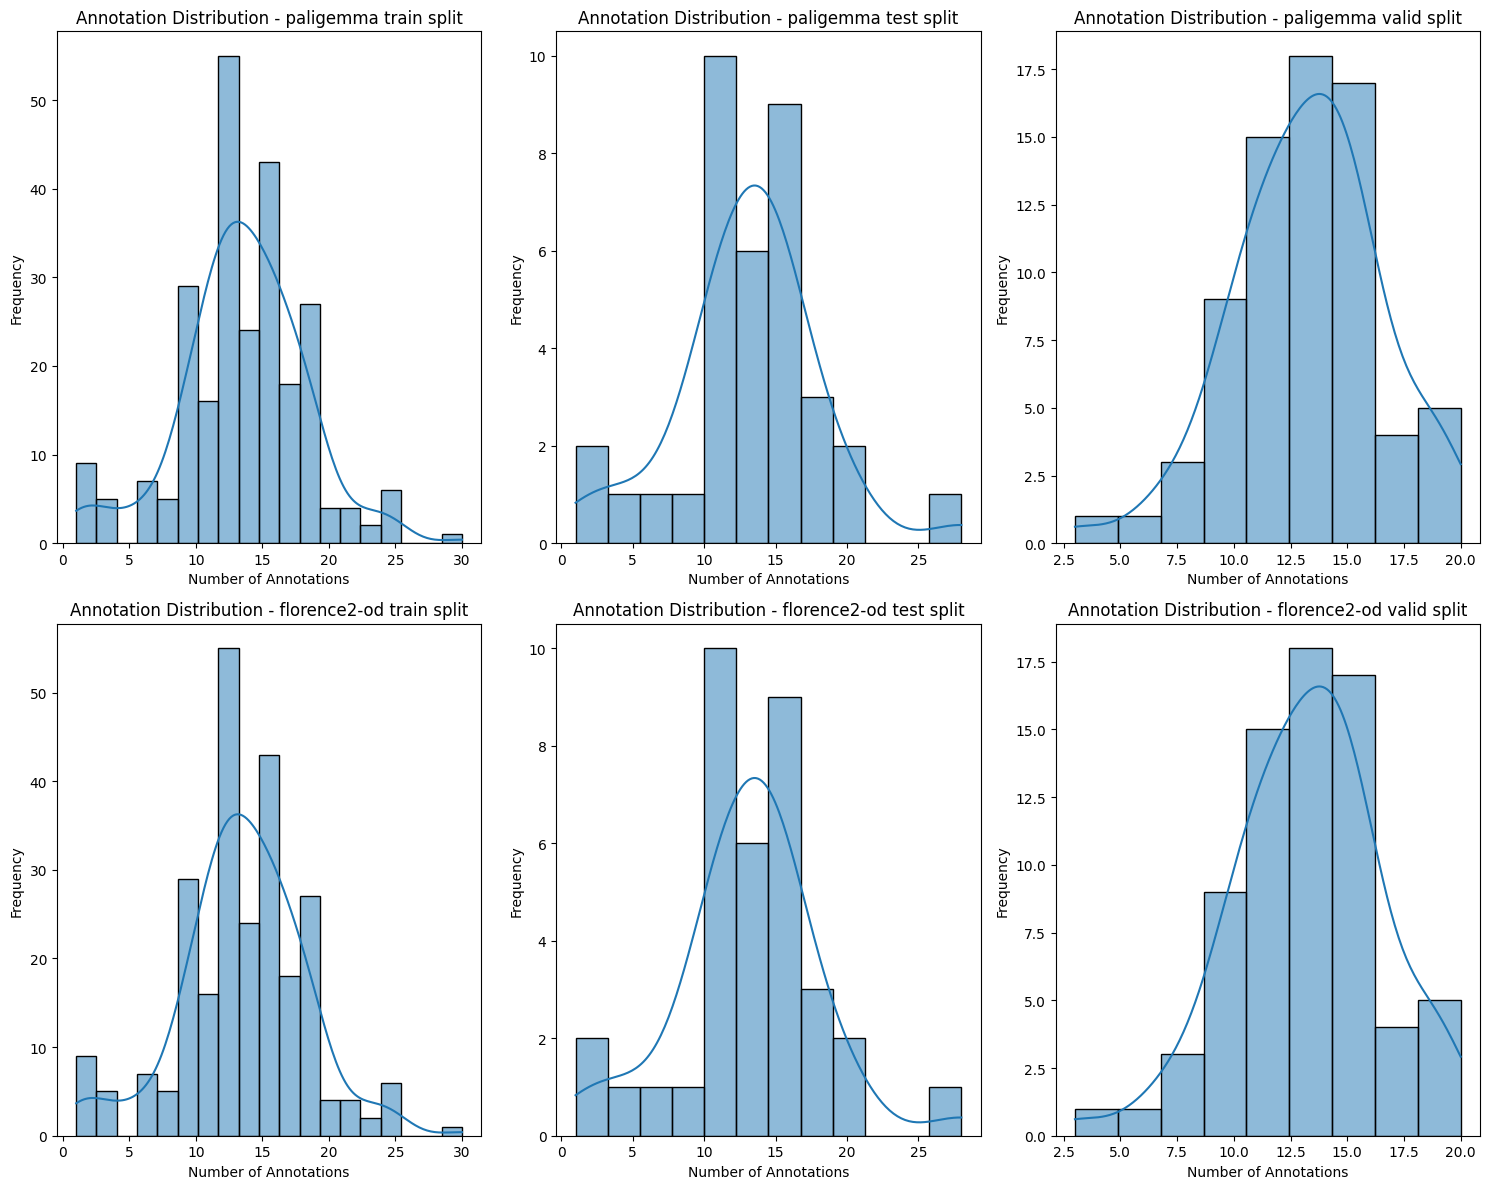

Analysis complete.


In [ ]:
# Usage
analyze_datasets(handler)
print("Analysis complete.")

In [ ]:
# Example usage for Florence2 dataset
display_first_five_records(handler, 'florence2-od')

image_id  \
12  BloodImage_00038_jpg.rf.1b0ce1635e11b3b49302de527c86bb02.jpg   
16  BloodImage_00044_jpg.rf.1c44102fcdf64fd178f1f16bb988d5cf.jpg   
34  BloodImage_00062_jpg.rf.fbed5373cd2e0e732092ed5c7b28aa19.jpg   
10  BloodImage_00090_jpg.rf.7e3d419774b20ef93d4ec6c4be8f64df.jpg   
5   BloodImage_00099_jpg.rf.0a65e56401cdd71253e7bc04917c3558.jpg   

    annotation_count  \
12                28   
16                20   
34                13   
10                15   
5                 18   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            annotations  
12  {'image': 'BloodImage_00038_jpg.rf.1b0ce1635e11b3b49302de527c86bb02.jpg', 'prefix': '<OD>', 'suffix': 'WBC<loc_648><loc_633><loc_833><loc_890>RBC<loc_242><loc_810><loc_398><loc_948>RBC<loc_150><loc_831><loc_303><loc_992>RBC<loc_17><loc_544><loc_142><loc_750>RBC<loc_30><loc_650><loc_155><loc_856>RBC<loc_22><loc_160><loc_147><loc_367>RBC<loc_34><loc_296><loc_191><loc_506>RBC<loc_95><loc_404><loc_219><loc_615>RBC<loc_145><loc_467><loc_269><loc_677>RBC<loc_183><loc_485><loc_306><loc_696>RBC<loc_...  
16  {'image': 'BloodImage_00044_jpg.rf.1c44102fcdf64fd178f1f16bb988d5cf.jpg', 'prefix': '<OD>', 'suffix': 'WBC<loc_306><loc_535><loc_539><loc_856>WBC<loc_2><loc_83><loc_189><loc_321>RBC<loc_106><loc_773><loc_327><loc_985>RBC<loc_108><loc_600><loc_241><loc_798>RBC<loc_639><loc_113><loc_808><loc_335>RBC<loc_77><loc_296><loc_245><loc_519>RBC<loc_323><loc_123><loc_492><loc_346>RBC<loc_266><loc_302><loc_434><loc_525>RBC<loc_470><loc_48><loc_639><loc_271>RBC<loc_786><loc_350><loc_955><loc_573>RBC<loc_...  
34  {'image': 'BloodImage_00062_jpg.rf.fbed5373cd2e0e732092ed5c7b28aa19.jpg', 'prefix': '<OD>', 'suffix': 'RBC<loc_219><loc_335><loc_413><loc_527>RBC<loc_563><loc_590><loc_705><loc_779>RBC<loc_670><loc_629><loc_873><loc_871>RBC<loc_814><loc_481><loc_983><loc_683>RBC<loc_613><loc_319><loc_825><loc_544>RBC<loc_638><loc_117><loc_784><loc_321>RBC<loc_581><loc_2><loc_728><loc_204>RBC<loc_853><loc_100><loc_999><loc_304>RBC<loc_270><loc_2><loc_447><loc_194>RBC<loc_95><loc_2><loc_250><loc_150>RBC<loc_2>...  
10  {'image': 'BloodImage_00090_jpg.rf.7e3d419774b20ef93d4ec6c4be8f64df.jpg', 'prefix': '<OD>', 'suffix': 'RBC<loc_359><loc_298><loc_559><loc_506>RBC<loc_370><loc_2><loc_544><loc_175>RBC<loc_209><loc_163><loc_383><loc_338>RBC<loc_125><loc_110><loc_270><loc_283>RBC<loc_773><loc_2><loc_923><loc_165>RBC<loc_166><loc_423><loc_311><loc_598>RBC<loc_638><loc_798><loc_783><loc_973>RBC<loc_720><loc_779><loc_866><loc_954>RBC<loc_363><loc_785><loc_508><loc_960>RBC<loc_736><loc_167><loc_892><loc_394>RBC<loc...  
5   {'image': 'BloodImage_00099_jpg.rf.0a65e56401cdd71253e7bc04917c3558.jpg', 'prefix': '<OD>', 'suffix': 'RBC<loc_595><loc_398><loc_742><loc_598>RBC<loc_225><loc_313><loc_398><loc_519>RBC<loc_180><loc_446><loc_353><loc_692>RBC<loc_641><loc_508><loc_814><loc_754>RBC<loc_794><loc_267><loc_939><loc_498>RBC<loc_677><loc_25><loc_834><loc_252>RBC<loc_842><loc_748><loc_999><loc_975>RBC<loc_852><loc_548><loc_999><loc_744>RBC<loc_81><loc_688><loc_230><loc_883>RBC<loc_455><loc_46><loc_638><loc_233>RBC<lo...

In [ ]:
# Example usage for paligemma dataset
display_first_five_records(handler, 'paligemma')

image_id  \
2   BloodImage_00038_jpg.rf.1b0ce1635e11b3b49302de527c86bb02.jpg   
4   BloodImage_00044_jpg.rf.1c44102fcdf64fd178f1f16bb988d5cf.jpg   
29  BloodImage_00062_jpg.rf.fbed5373cd2e0e732092ed5c7b28aa19.jpg   
17  BloodImage_00090_jpg.rf.7e3d419774b20ef93d4ec6c4be8f64df.jpg   
5   BloodImage_00099_jpg.rf.0a65e56401cdd71253e7bc04917c3558.jpg   

    annotation_count  \
2                 28   
4                 20   
29                13   
17                15   
5                 18   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            annotations  
2   {'image': 'BloodImage_00038_jpg.rf.1b0ce1635e11b3b49302de527c86bb02.jpg', 'prefix': 'detect Platelets ; RBC ; WBC', 'suffix': '<loc0648><loc0664><loc0910><loc0852> WBC ; <loc0829><loc0248><loc0970><loc0408> RBC ; <loc0851><loc0153><loc1015><loc0310> RBC ; <loc0556><loc0017><loc0768><loc0145> RBC ; <loc0665><loc0030><loc0876><loc0158> RBC ; <loc0164><loc0022><loc0375><loc0150> RBC ; <loc0302><loc0035><loc0518><loc0195> RBC ; <loc0413><loc0097><loc0629><loc0224> RBC ; <loc0477><loc0148><loc069...  
4   {'image': 'BloodImage_00044_jpg.rf.1c44102fcdf64fd178f1f16bb988d5cf.jpg', 'prefix': 'detect Platelets ; RBC ; WBC', 'suffix': '<loc0548><loc0313><loc0876><loc0552> WBC ; <loc0085><loc0001><loc0328><loc0193> WBC ; <loc0791><loc0108><loc1009><loc0334> RBC ; <loc0614><loc0110><loc0817><loc0246> RBC ; <loc0115><loc0654><loc0343><loc0827> RBC ; <loc0302><loc0078><loc0531><loc0251> RBC ; <loc0125><loc0331><loc0354><loc0504> RBC ; <loc0309><loc0272><loc0537><loc0444> RBC ; <loc0049><loc0481><loc027...  
29  {'image': 'BloodImage_00062_jpg.rf.fbed5373cd2e0e732092ed5c7b28aa19.jpg', 'prefix': 'detect Platelets ; RBC ; WBC', 'suffix': '<loc0343><loc0224><loc0539><loc0422> RBC ; <loc0603><loc0576><loc0797><loc0721> RBC ; <loc0644><loc0686><loc0891><loc0894> RBC ; <loc0492><loc0833><loc0699><loc1006> RBC ; <loc0326><loc0627><loc0556><loc0844> RBC ; <loc0119><loc0652><loc0328><loc0803> RBC ; <loc0002><loc0595><loc0209><loc0745> RBC ; <loc0102><loc0873><loc0311><loc1023> RBC ; <loc0002><loc0276><loc019...  
17  {'image': 'BloodImage_00090_jpg.rf.7e3d419774b20ef93d4ec6c4be8f64df.jpg', 'prefix': 'detect Platelets ; RBC ; WBC', 'suffix': '<loc0305><loc0368><loc0518><loc0572> RBC ; <loc0002><loc0379><loc0179><loc0556> RBC ; <loc0166><loc0214><loc0345><loc0392> RBC ; <loc0113><loc0128><loc0290><loc0276> RBC ; <loc0002><loc0792><loc0168><loc0945> RBC ; <loc0433><loc0169><loc0612><loc0318> RBC ; <loc0817><loc0652><loc0996><loc0801> RBC ; <loc0797><loc0737><loc0977><loc0886> RBC ; <loc0804><loc0371><loc098...  
5   {'image': 'BloodImage_00099_jpg.rf.0a65e56401cdd71253e7bc04917c3558.jpg', 'prefix': 'detect Platelets ; RBC ; WBC', 'suffix': '<loc0407><loc0609><loc0612><loc0760> RBC ; <loc0320><loc0230><loc0531><loc0408> RBC ; <loc0456><loc0184><loc0708><loc0361> RBC ; <loc0520><loc0656><loc0772><loc0833> RBC ; <loc0273><loc0812><loc0509><loc0961> RBC ; <loc0025><loc0692><loc0258><loc0854> RBC ; <loc0765><loc0862><loc0998><loc1023> RBC ; <loc0561><loc0872><loc0761><loc1023> RBC ; <loc0704><loc0083><loc090...

In [ ]:
import pandas as pd
import json
from IPython.display import display, Markdown

def find_and_print_annotation(handler, image_id):
    formats = ['paligemma', 'florence2-od']
    for format in formats:
        dataset = handler.get_dataset(format)
        if dataset:
            # Convert the dataset to a DataFrame
            df = dataset['test'].to_pandas()

            # Drop the 'image' column since it's in bytes format
            df = df.drop(columns=['image'])

            # Find the record with the specified image_id
            record = df[df['image_id'] == image_id]

            if not record.empty:
                print(f"\nRecord found in {format}:")
                annotation = record.iloc[0]['annotations']
                # Pretty print the annotation output
                pretty_annotation = json.dumps(annotation, indent=4)
                display(Markdown(f"```json\n{pretty_annotation}\n```"))
            else:
                print(f"No record found with image_id {image_id} in {format} dataset.")
        else:
            print(f"{format} dataset is not available.")

In [ ]:
# Example usage: Replace with the actual image_id you want to search for
image_id_to_find = 'BloodImage_00038_jpg.rf.1b0ce1635e11b3b49302de527c86bb02.jpg'
find_and_print_annotation(handler, image_id_to_find)


Record found in paligemma:


```json
{
    "image": "BloodImage_00038_jpg.rf.1b0ce1635e11b3b49302de527c86bb02.jpg",
    "prefix": "detect Platelets ; RBC ; WBC",
    "suffix": "<loc0648><loc0664><loc0910><loc0852> WBC ; <loc0829><loc0248><loc0970><loc0408> RBC ; <loc0851><loc0153><loc1015><loc0310> RBC ; <loc0556><loc0017><loc0768><loc0145> RBC ; <loc0665><loc0030><loc0876><loc0158> RBC ; <loc0164><loc0022><loc0375><loc0150> RBC ; <loc0302><loc0035><loc0518><loc0195> RBC ; <loc0413><loc0097><loc0629><loc0224> RBC ; <loc0477><loc0148><loc0693><loc0275> RBC ; <loc0497><loc0187><loc0712><loc0313> RBC ; <loc0503><loc0273><loc0725><loc0424> RBC ; <loc0396><loc0424><loc0618><loc0574> RBC ; <loc0238><loc0297><loc0503><loc0470> RBC ; <loc0249><loc0224><loc0332><loc0278> Platelets ; <loc0132><loc0596><loc0215><loc0651> Platelets ; <loc0200><loc0449><loc0375><loc0596> RBC ; <loc0087><loc0824><loc0262><loc0971> RBC ; <loc0032><loc0755><loc0294><loc0904> RBC ; <loc0273><loc0870><loc0535><loc1020> RBC ; <loc0439><loc0899><loc0637><loc1023> RBC ; <loc0488><loc0760><loc0689><loc0908> RBC ; <loc0407><loc0702><loc0608><loc0851> RBC ; <loc0379><loc0627><loc0580><loc0776> RBC ; <loc0708><loc0875><loc0908><loc1023> RBC ; <loc0823><loc0875><loc1023><loc1023> RBC ; <loc0823><loc0780><loc1023><loc0929> RBC ; <loc0032><loc0219><loc0232><loc0368> RBC ; <loc0064><loc0616><loc0264><loc0764> RBC"
}
```


Record found in florence2-od:


```json
{
    "image": "BloodImage_00038_jpg.rf.1b0ce1635e11b3b49302de527c86bb02.jpg",
    "prefix": "<OD>",
    "suffix": "WBC<loc_648><loc_633><loc_833><loc_890>RBC<loc_242><loc_810><loc_398><loc_948>RBC<loc_150><loc_831><loc_303><loc_992>RBC<loc_17><loc_544><loc_142><loc_750>RBC<loc_30><loc_650><loc_155><loc_856>RBC<loc_22><loc_160><loc_147><loc_367>RBC<loc_34><loc_296><loc_191><loc_506>RBC<loc_95><loc_404><loc_219><loc_615>RBC<loc_145><loc_467><loc_269><loc_677>RBC<loc_183><loc_485><loc_306><loc_696>RBC<loc_267><loc_492><loc_414><loc_708>RBC<loc_414><loc_388><loc_561><loc_604>RBC<loc_291><loc_233><loc_459><loc_492>Platelets<loc_219><loc_244><loc_272><loc_325>Platelets<loc_583><loc_129><loc_636><loc_210>RBC<loc_439><loc_196><loc_583><loc_367>RBC<loc_805><loc_85><loc_948><loc_256>RBC<loc_738><loc_31><loc_883><loc_288>RBC<loc_850><loc_267><loc_997><loc_523>RBC<loc_878><loc_429><loc_999><loc_623>RBC<loc_742><loc_477><loc_888><loc_673>RBC<loc_686><loc_398><loc_831><loc_594>RBC<loc_613><loc_371><loc_758><loc_567>RBC<loc_855><loc_692><loc_999><loc_888>RBC<loc_855><loc_804><loc_999><loc_999>RBC<loc_763><loc_804><loc_908><loc_999>RBC<loc_214><loc_31><loc_359><loc_227>RBC<loc_602><loc_63><loc_747><loc_258>"
}
```

## Push to Hugging Face Hub

In [ ]:
# Push to Hugging Face Hub
florence2_ds.push_to_hub("dwb2023/roboflow100-bccd-florence2-temp")
paligemma_ds.push_to_hub("dwb2023/roboflow-bccd-paligemma-temp")


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/255 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/73 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/255 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/73 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/dwb2023/roboflow-bccd-paligemma-temp/commit/af65cc975c40815414053a02688c0c52ec9acb41', commit_message='Upload dataset', commit_description='', oid='af65cc975c40815414053a02688c0c52ec9acb41', pr_url=None, pr_revision=None, pr_num=None)

## For additional information

- [Hugging Face](https://huggingface.co/blog/paligemma)
- [Roboflow Blog](https://blog.roboflow.com/fine-tune-florence-2-object-detection/)
- [Datature](https://www.datature.io/blog/a-primer-on-fine-tuning-paligemma-and-vlms)